# Translation of a discrete 1D signal


#### wave equation

$$
\frac{\partial^2 u}{\partial t^2}
 = 
 v^2 \frac{\partial^2 u}{\partial x^2}
$$


##### simple sine solution

$$
u(x, t) = \sin\left( \frac{2 \pi x}{\lambda} -2\pi f t\right)
= \sin\left( 2 \pi f \, ( \frac{x}{v(f)} -t) \right)
$$

$$\lambda = \dfrac{v}{f}$$
##### plane wave per mode



$$ 
u_f(x,t) 
= 
 A \exp(- 2\pi i f \left[ \frac{x}{v(f)} - t \right] )
 +
 B \exp(- 2\pi i f \left[ \frac{x}{v(f)} + t \right] )
$$


In [1]:
%matplotlib inline

import numpy as np
import scipy.fft as ft
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tck

rng = np.random.default_rng()

In [2]:
class TravelSignal:
    """
    Model an arbitrary digitised signal that can be translated to another position and time.
    """

    def __init__(self, signal, sample_rate, t_0 = 0, x_0 = 0, periodic=True, interp1d_kw = None):
        """
        Initialise by saving the raw signal
        
        Parameters
        ----------
        signal : arraylike
            The raw signal to wrap.
        sample_rate : float
            Sample rate of the raw signal.
        t_0 : float, optional
            Time that this signal is sent out.
        x_0 : float, optional
            Location that this signal is sent out from.
        periodic : bool, optional
            Translated signal is 0 if it is not periodic
            and the time/distance is outside the samples.
        interp1d_kw : bool or dict, optional
            Use scipy.interpolate's interp1d_kw for interpolation.
            Set to True, or a dictionary to enable.
            Dictionary will be entered in as **kwargs.
        """

        self.raw = signal
        self.periodic = periodic

        self.sample_rate = sample_rate # Hz
        self.sample_length = len(self.raw)
        self.time_length = self.sample_length*sample_rate # s
        
        self.x_0 = x_0
        self.t_0 = t_0

        # choose interpolation method
        if not interp1d_kw:
            self.interp_f = None

        else:
            # offload interpolation to scipy.interpolate
            import scipy.interpolate as interp

            interp1d_kw_defaults = {
                "copy": False,
                "kind": 'linear',
                "assume_sorted": True,
                "bounds_error": True
            }

            if self.periodic:
                interp1d_kw_defaults['bounds_error'] = False
                interp1d_kw_defaults['fill_value'] = (self.raw[-1], self.raw[0])
                
            # merge kwargs
            if interp1d_kw is not True:
                interp1d_kw = { **interp1d_kw_defaults, **interp1d_kw }

            self.interp_f = interp.interp1d(
                                np.arange(0, self.sample_length),
                                self.raw,
                                **interp1d_kw
                            )
        
    def __len__(self):
        return self.sample_length
        
    def __call__(self, t_f = None, x_f = None, **kwargs):
        """
        Allow this class to be used as a function.
        """
        return self._translate(t_f, x_f, **kwargs)[0]
    
    def _translate(self, t_f = None, x_f = None, t_0 = None, x_0 = None, velocity = None):
        """
        Translate the signal from (t_0, x_0) to (t_f, x_f) with optional velocity.
        
        Returns the signal at (t_f, x_f)
        """
        
        if t_0 is None:
            t_0 = self.t_0
        
        if velocity is None:
            velocity = 1


        ## spatial offset
        if x_f is None:
            spatial_time_offset = 0
        else:
            x_f = np.asarray(x_f)
            if x_0 is None:
                x_0 = self.x_0

            spatial_time_offset = np.sum(np.sqrt( (x_f - x_0)**2 )/velocity)

        ## temporal offset
        if t_f is None:
            temporal_time_offset = 0
        else:
            t_f = np.asarray(t_f)
                
            if t_0 is None:
                t_0 = self.t_0
        
            temporal_time_offset = t_f - t_0

        # total offset
        total_time_offset = spatial_time_offset + temporal_time_offset
        n_offset = (total_time_offset * sample_rate )

        # periodic signal
        if self.periodic:
            n_offset = n_offset % self.sample_length

        # non-periodic and outside the bounds
        else:
            mask_idx = np.nonzero( (0 > n_offset) | (n_offset >= self.sample_length) )
            n_offset[mask_idx] = 0

        # offload to scipy interpolation
        if self.interp_f:
            amplitude = self.interp_f(n_offset)
        
        # self written linear interpolation
        else:
            n_offset_eps, n_offset_int = np.modf(n_offset)
            n_offset_int = n_offset.astype(int)

            if True:
                amplitude = (1-n_offset_eps) * self.raw[n_offset_int] \
                            + n_offset_eps * self.raw[(n_offset_int + 1) % self.sample_length]

            # use nearest value instead of interpolation
            else:
                amplitude = self.raw[n_offset_int]

        if not self.periodic:
            amplitude[mask_idx] = 0
        
        return amplitude, total_time_offset

# Testing:

### Interpolation: Sine wave

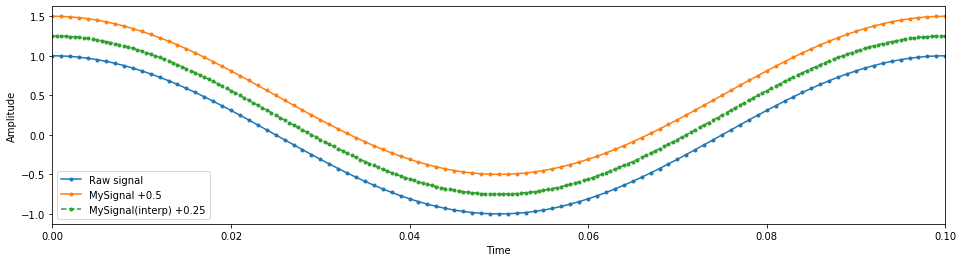

In [3]:
# Sine wave
sample_rate = 1e3 # Hz
f_sine = 10
time   = np.arange(0, 1, 1/(sample_rate)) #s
time2   = np.arange(0, 1, 1/(sample_rate*2)) #s
phase_offset = 0

signal_func = lambda t: np.cos(2*np.pi*f_sine*t + phase_offset)

mysignal = TravelSignal(signal_func(time), sample_rate)

fig, ax = plt.subplots(figsize=(16,4))
ax.plot(time,  signal_func(time),    '.-',  label="Raw signal")
ax.plot(time,  mysignal(time)+0.5,   '.-',  label="MySignal +0.5")
ax.plot(time2, mysignal(time2)+0.25, '.--', label="MySignal(interp) +0.25")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time")
ax.set_xlim(0, 1/f_sine)
ax.legend()
plt.show();

### Extrapolation: Sine wave

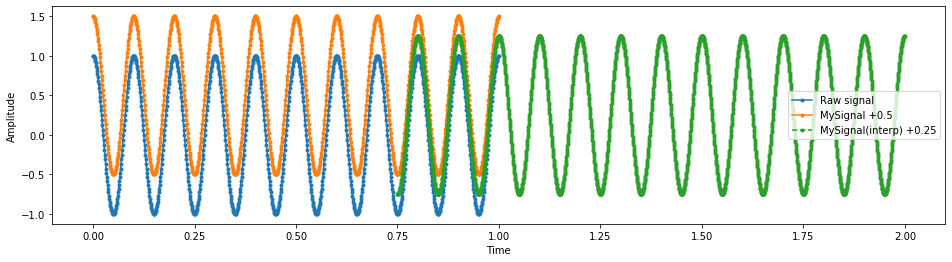

In [4]:
# Sine wave
sample_rate = 1e3 # Hz
f_sine = 10
time   = np.arange(0, 1, 1/(sample_rate)) #s
time2   = np.arange(3/4, 2, 1/(sample_rate*2)) #s
phase_offset = 0

signal_func = lambda t: np.cos(2*np.pi*f_sine*t + phase_offset)

mysignal = TravelSignal(signal_func(time), sample_rate)

fig, ax = plt.subplots(figsize=(16,4))
ax.plot(time,  signal_func(time),    '.-',  label="Raw signal")
ax.plot(time,  mysignal(time)+0.5,   '.-',  label="MySignal +0.5")
ax.plot(time2, mysignal(time2)+0.25, '.--', label="MySignal(interp) +0.25")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time")
ax.legend()
plt.show();

### Interpolation: Delta function

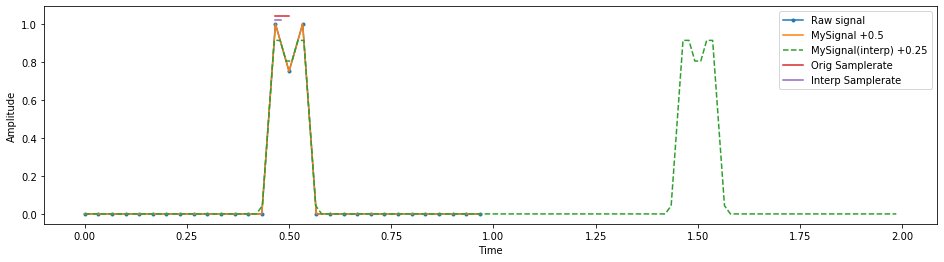

In [5]:
## 1d signal: Delta peak with time interval
sample_rate = 3e1 # Hz
interp_sample_rate = 2.3*sample_rate
time   = np.arange(0, 1, 1/sample_rate) #s
time2  = np.arange(0, 2, 1/(interp_sample_rate)) #s

signal = np.zeros(len(time))
if False:
    signal[len(signal)//2] = 1
else:
    signal[len(signal)//2-1] = 1
    signal[len(signal)//2] = 0.75
    signal[len(signal)//2+1] = 1

mysignal = TravelSignal(signal, sample_rate)
time_signal,  time_offsets  = mysignal._translate(time)
time2_signal, time2_offsets = mysignal._translate(time2)

raw_max_idx = np.argmax(signal)
my_max_idx  = np.argmax(mysignal(time))
my2_max_idx = np.argmax(mysignal(time2))


fig, ax = plt.subplots(1,1,sharex=True, figsize=(16,4))
ax.plot(time,  mysignal.raw,  '.-', label="Raw signal")
ax.plot(time,  time_signal,   '-',  label="MySignal +0.5")
ax.plot(time2, time2_signal,  '--', label="MySignal(interp) +0.25")
ax.plot(np.array([0, 1/sample_rate]) + time[raw_max_idx], [1.04, 1.04], label="Orig Samplerate")
ax.plot(np.array([0, 1/interp_sample_rate]) + time[raw_max_idx], [1.02, 1.02], label="Interp Samplerate")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time")
ax.legend()

plt.show();

## Non-Periodicity: Gaussian pulse

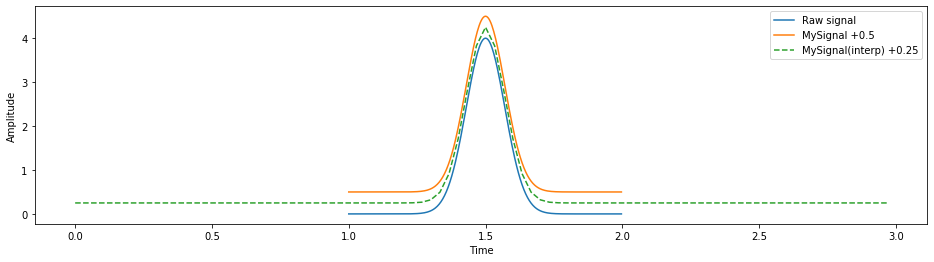

In [6]:
sample_rate = 3e2 # Hz
interp_sample_rate = sample_rate * 1/10 # Hz

t_offset = 1
periodic = False

time   = t_offset + np.arange(0, 1, 1/sample_rate) #s
time2  = np.arange(0, 3*t_offset, 1/(interp_sample_rate)) #s

def gaussian(x, mu, sigma ):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(- (x-mu)**2 / sigma**2 )

signal = gaussian(time, time[len(time)//2], (time[-1] - time[0])/10)


mysignal = TravelSignal(signal, sample_rate, t_0 = t_offset, periodic=periodic)

fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time")

ax.plot(time,  signal,                       label='Raw signal')
ax.plot(time,  mysignal(time)+0.5,     '-',  label="MySignal +0.5")
ax.plot( time2, mysignal(time2)+0.25 , '--', label="MySignal(interp) +0.25")
ax.legend()

plt.show();